#Подключаем библиотеки

In [1]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as MSE

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from scipy.stats import norm

from prophet import Prophet



# from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.performance_metrics.forecasting import smape_loss



import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

#Работа с выделением признаков


#Прочитаем данные

In [3]:
!pip install featuretools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.2/619.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.4/754.4 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.35
    Uninstalling holidays-0.35:
      Successfully uninstalled holidays-0.35


In [4]:
from featuretools.demo.weather import load_weather # стандартный датасет Погода (минимальные температуры от дат)

In [5]:
es = load_weather() # датасет с температурами (минимальные дневные температуры) формата DataFrame

es["temperatures"].head(10) #es - EntitySet или набор сущностей

,id,Date,Temp
0,0,1981-01-01,20.7
1,1,1981-01-02,17.9
2,2,1981-01-03,18.8
3,3,1981-01-04,14.6
4,4,1981-01-05,15.8
5,5,1981-01-06,15.8
6,6,1981-01-07,15.8
7,7,1981-01-08,17.4
8,8,1981-01-09,21.8
9,9,1981-01-10,20.0


In [7]:
data =es["temperatures"]

In [8]:
data

,id,Date,Temp
0,0,1981-01-01,20.7
1,1,1981-01-02,17.9
2,2,1981-01-03,18.8
3,3,1981-01-04,14.6
4,4,1981-01-05,15.8
...,...,...,...
3645,3645,1990-12-27,14.0
3646,3646,1990-12-28,13.6
3647,3647,1990-12-29,13.5
3648,3648,1990-12-30,15.7


In [9]:
data.columns = ['id', 'date', 'y']

In [10]:
data

,id,date,y
0,0,1981-01-01,20.7
1,1,1981-01-02,17.9
2,2,1981-01-03,18.8
3,3,1981-01-04,14.6
4,4,1981-01-05,15.8
...,...,...,...
3645,3645,1990-12-27,14.0
3646,3646,1990-12-28,13.6
3647,3647,1990-12-29,13.5
3648,3648,1990-12-30,15.7


<Axes: >

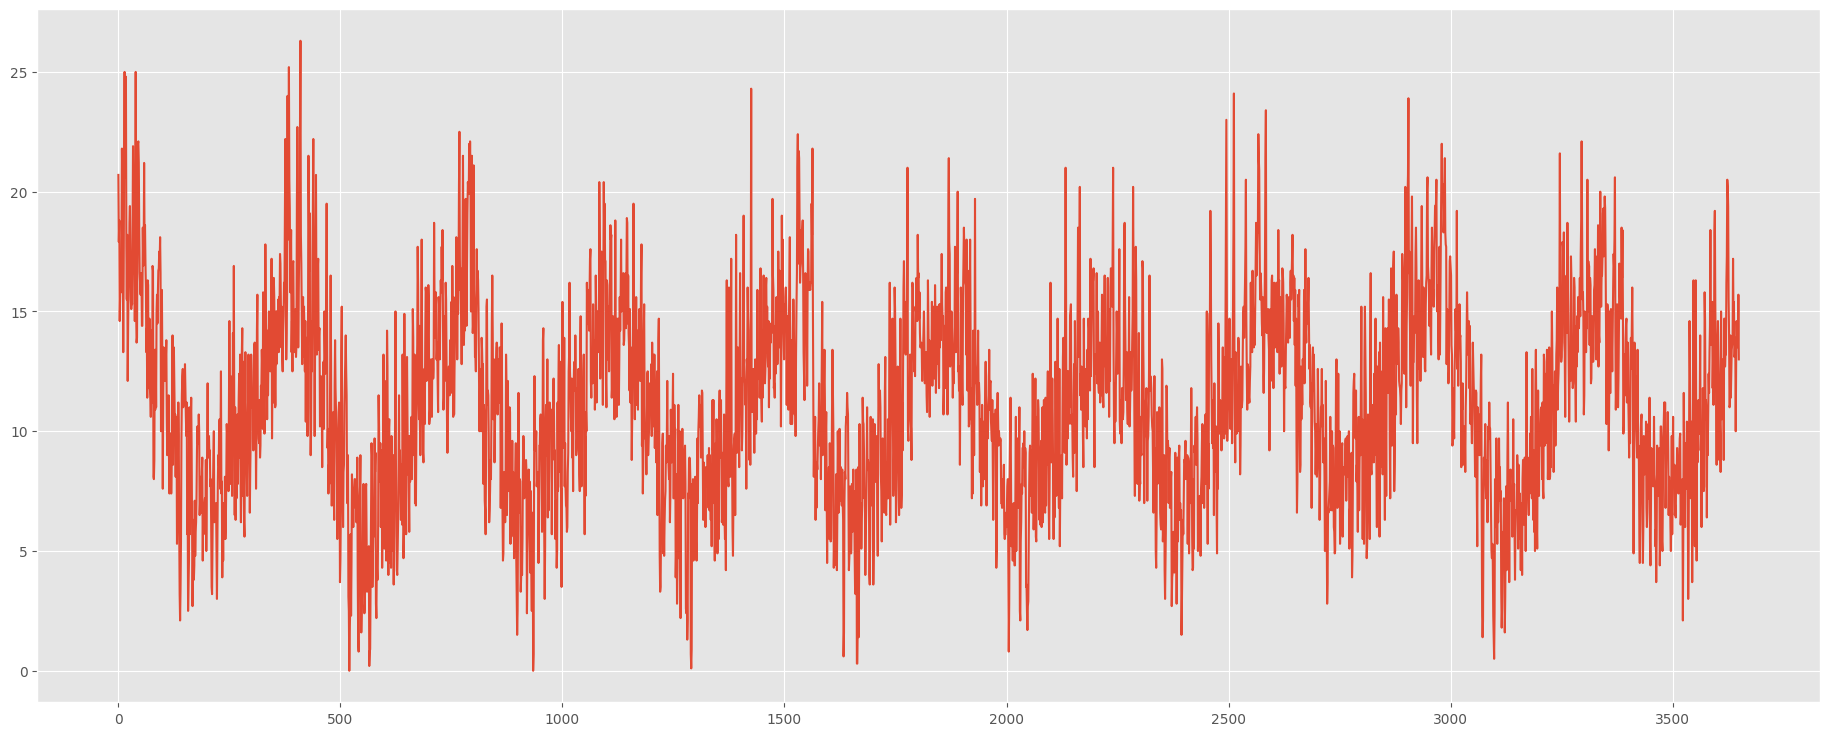

In [11]:
data['y'].plot()

In [22]:
datats = data.copy()

#Получили исходный временной ряд

In [23]:
datats.head()

,id,date,y
0,0,1981-01-01,20.7
1,1,1981-01-02,17.9
2,2,1981-01-03,18.8
3,3,1981-01-04,14.6
4,4,1981-01-05,15.8


In [24]:
datats['id'] = 1

In [25]:
datats

,id,date,y
0,1,1981-01-01,20.7
1,1,1981-01-02,17.9
2,1,1981-01-03,18.8
3,1,1981-01-04,14.6
4,1,1981-01-05,15.8
...,...,...,...
3645,1,1990-12-27,14.0
3646,1,1990-12-28,13.6
3647,1,1990-12-29,13.5
3648,1,1990-12-30,15.7


In [17]:
# Добавление признака "месяц"
#datats['month'] = pd.to_datetime(datats['date']).dt.month

# Добавление признака "день недели"
#datats['weekday'] = pd.to_datetime(datats['date']).dt.weekday

In [14]:
!pip install tsfresh -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 8.9 MB/s eta 0:00:00


#Получаем id для последовательности

In [27]:
from tsfresh.utilities.dataframe_functions import roll_time_series
df_rolled = roll_time_series(datats, column_id="id", column_sort='date')

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|█████████▉| 3645/3650 [00:14<00:00, 86.47it/s]/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:350: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return [grouped_data.apply(_f)]
Rolling: 100%|██████████| 3650/3650 [00:14<00:00, 258.17it/s]


In [28]:
df_rolled.head(5)

,id,date,y
0,"(1, 1981-01-01 00:00:00)",1981-01-01,20.7
1,"(1, 1981-01-02 00:00:00)",1981-01-01,20.7
2,"(1, 1981-01-02 00:00:00)",1981-01-02,17.9
3,"(1, 1981-01-03 00:00:00)",1981-01-01,20.7
4,"(1, 1981-01-03 00:00:00)",1981-01-02,17.9


#Извлекаем признаки

In [29]:
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_selection import select_features
from tsfresh.utilities.dataframe_functions import impute
# Извлечение признаков
extracted_features = extract_features(df_rolled, column_id='id', column_sort='date')



Feature Extraction: 100%|██████████| 3650/3650 [4:51:19<00:00,  4.79s/it]


In [30]:
# Заполнение пропущенных значений
imputed_features = impute(extracted_features)


/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['y__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [31]:
imputed_features.shape

(3650, 783)

In [32]:
imputed_features

y__variance_larger_than_standard_deviation  \
1 1981-01-01                                         0.0   
  1981-01-02                                         1.0   
  1981-01-03                                         1.0   
  1981-01-04                                         1.0   
  1981-01-05                                         1.0   
...                                                  ...   
  1990-12-27                                         1.0   
  1990-12-28                                         1.0   
  1990-12-29                                         1.0   
  1990-12-30                                         1.0   
  1990-12-31                                         1.0   

              y__has_duplicate_max  y__has_duplicate_min  y__has_duplicate  \
1 1981-01-01                   0.0                   0.0               0.0   
  1981-01-02                   0.0                   0.0               0.0   
  1981-01-03                   0.0                   0.0               0.0   
  1981-01-04                   0.0                   0.0               0.0   
  1981-01-05                   0.0                   0.0               0.0   
...                            ...                   ...               ...   
  1990-12-27                   0.0                   1.0               1.0   
  1990-12-28                   0.0                   1.0               1.0   
  1990-12-29                   0.0                   1.0               1.0   
  1990-12-30                   0.0                   1.0               1.0   
  1990-12-31                   0.0                   1.0               1.0   

              y__sum_values  y__abs_energy  y__mean_abs_change  \
1 1981-01-01           20.7         428.49            2.199127   
  1981-01-02           38.6         748.90            2.800000   
  1981-01-03           57.4        1102.34            1.850000   
  1981-01-04           72.0        1315.50            2.633333   
  1981-01-05           87.8        1565.14            2.275000   
...                     ...            ...                 ...   
  1990-12-27        40743.0      515756.12            2.134019   
  1990-12-28        40756.6      515941.08            2.133544   
  1990-12-29        40770.1      516123.33            2.132986   
  1990-12-30        40785.8      516369.82            2.133004   
  1990-12-31        40798.8      516538.82            2.133160   

              y__mean_change  y__mean_second_derivative_central  y__median  \
1 1981-01-01       -0.005225                           0.000769      20.70   
  1981-01-02       -2.800000                           0.000769      19.30   
  1981-01-03       -0.950000                           1.850000      18.80   
  1981-01-04       -2.033333                          -0.350000      18.35   
  1981-01-05       -1.225000                           0.666667      17.90   
...                      ...                                ...        ...   
  1990-12-27       -0.001838                           0.000302      11.00   
  1990-12-28       -0.001947                           0.000329      11.00   
  1990-12-29       -0.001974                           0.000370      11.00   
  1990-12-30       -0.001371                           0.000685      11.00   
  1990-12-31       -0.002110                           0.000014      11.00   

              ...  y__fourier_entropy__bins_5  y__fourier_entropy__bins_10  \
1 1981-01-01  ...                    0.125256                     0.125256   
  1981-01-02  ...                   -0.000000                    -0.000000   
  1981-01-03  ...                    0.693147                     0.693147   
  1981-01-04  ...                    0.636514                     0.636514   
  1981-01-05  ...                    0.636514                     0.636514   
...           ...                         ...                          ...   
  1990-12-27  ...                    0.125256                     0.125256   
  

In [33]:
datats

,id,date,y
0,1,1981-01-01,20.7
1,1,1981-01-02,17.9
2,1,1981-01-03,18.8
3,1,1981-01-04,14.6
4,1,1981-01-05,15.8
...,...,...,...
3645,1,1990-12-27,14.0
3646,1,1990-12-28,13.6
3647,1,1990-12-29,13.5
3648,1,1990-12-30,15.7


# Выбор значимых признаков

In [34]:
# Выбор значимых признаков
selected_features = select_features(imputed_features.reset_index(), datats['y'])

In [35]:
selected_features

,"y__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0",y__mean_change,y__time_reversal_asymmetry_statistic__lag_3,"y__fft_coefficient__attr_""imag""__coeff_11","y__fft_coefficient__attr_""imag""__coeff_13",y__time_reversal_asymmetry_statistic__lag_1,y__time_reversal_asymmetry_statistic__lag_2,"y__fft_coefficient__attr_""imag""__coeff_15","y__fft_coefficient__attr_""imag""__coeff_21","y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0",...,y__c3__lag_3,"y__fft_coefficient__attr_""real""__coeff_13","y__fft_coefficient__attr_""real""__coeff_66","y__fft_coefficient__attr_""angle""__coeff_96","y__fft_coefficient__attr_""real""__coeff_98","y__fft_coefficient__attr_""real""__coeff_15",y__longest_strike_above_mean,"y__fft_coefficient__attr_""angle""__coeff_71",y__large_standard_deviation__r_0.35000000000000003,"y__fft_coefficient__attr_""imag""__coeff_80"
0,0.000000,-0.005225,0.000000,-138.529768,-127.202089,0.000000,0.000000,-115.610146,-85.886473,0.000000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,0.0,-37.467150,0.0,-23.606918
1,-2.800000,-2.800000,0.000000,-138.529768,-127.202089,0.000000,0.000000,-115.610146,-85.886473,0.000000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,1.0,-37.467150,1.0,-23.606918
2,-0.950000,-0.950000,0.000000,-138.529768,-127.202089,-1343.395000,0.000000,-115.610146,-85.886473,0.900000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,1.0,-37.467150,1.0,-23.606918
3,-2.033333,-2.033333,0.000000,-138.529768,-127.202089,-1679.847500,0.000000,-115.610146,-85.886473,-1.650000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,1.0,-37.467150,1.0,-23.606918
4,-1.225000,-1.225000,0.000000,-138.529768,-127.202089,-1625.058333,-3362.380000,-115.610146,-85.886473,-0.700000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,3.0,-37.467150,1.0,-23.606918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,-0.001838,-0.001838,-2.061926,-475.928278,237.743129,-0.213193,-2.701887,-257.854132,-353.929633,0.015532,...,1720.889469,-197.720651,-206.073132,157.787748,-17.786786,-78.410437,78.0,11.857937,0.0,53.548276
3646,-0.001947,-0.001947,-2.023379,-461.261915,238.056181,-0.321448,-2.360653,-258.747759,-352.755238,0.015376,...,1721.052863,-208.773857,-225.017868,169.235750,-0.078139,-79.661214,78.0,15.496893,0.0,56.886953
3647,-0.001974,-0.001974,-2.066760,-446.870190,238.149289,-0.372649,-2.299149,-259.709560,-351.430996,0.015333,...,1721.332555,-219.974355,-243.145283,-179.512804,16.944959,-81.023312,78.0,19.131626,0.0,59.101789
3648,-0.001371,-0.001371,-1.503234,-432.718189,238.070425,-0.144783,-2.174159,-260.683317,-349.877884,0.015333,...,1721.463399,-229.018095,-258.059755,-168.523210,35.357815,-80.195176,78.0,22.420844,0.0,60.610975


In [36]:
selected_features.isna().sum().sort_values()

y__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0    0
y__fft_coefficient__attr_"abs"__coeff_60                          0
y__fft_coefficient__attr_"abs"__coeff_87                          0
y__fft_coefficient__attr_"angle"__coeff_78                        0
y__fft_coefficient__attr_"imag"__coeff_70                         0
                                                                 ..
y__fft_coefficient__attr_"imag"__coeff_86                         0
y__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"      0
y__autocorrelation__lag_4                                         0
y__fft_coefficient__attr_"angle"__coeff_49                        0
y__fft_coefficient__attr_"imag"__coeff_80                         0
Length: 435, dtype: int64

In [ ]:
# selected_features.columns = [col.lower().replace('"', '').replace('(', '').replace(')', '').replace(',', '').replace(' ', '') for col in selected_features.columns]

In [ ]:
# selected_features.columns

In [37]:
selected_features.dtypes.value_counts()

float64    435
dtype: int64

In [38]:
selected_features.select_dtypes(exclude='float64')

""
0
1
2
3
4
...
3645
3646
3647
3648


In [ ]:
selected_features.drop(columns = 'level_1', inplace=True)

In [39]:
# Печать выбранных признаков
selected_features

,"y__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0",y__mean_change,y__time_reversal_asymmetry_statistic__lag_3,"y__fft_coefficient__attr_""imag""__coeff_11","y__fft_coefficient__attr_""imag""__coeff_13",y__time_reversal_asymmetry_statistic__lag_1,y__time_reversal_asymmetry_statistic__lag_2,"y__fft_coefficient__attr_""imag""__coeff_15","y__fft_coefficient__attr_""imag""__coeff_21","y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0",...,y__c3__lag_3,"y__fft_coefficient__attr_""real""__coeff_13","y__fft_coefficient__attr_""real""__coeff_66","y__fft_coefficient__attr_""angle""__coeff_96","y__fft_coefficient__attr_""real""__coeff_98","y__fft_coefficient__attr_""real""__coeff_15",y__longest_strike_above_mean,"y__fft_coefficient__attr_""angle""__coeff_71",y__large_standard_deviation__r_0.35000000000000003,"y__fft_coefficient__attr_""imag""__coeff_80"
0,0.000000,-0.005225,0.000000,-138.529768,-127.202089,0.000000,0.000000,-115.610146,-85.886473,0.000000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,0.0,-37.467150,0.0,-23.606918
1,-2.800000,-2.800000,0.000000,-138.529768,-127.202089,0.000000,0.000000,-115.610146,-85.886473,0.000000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,1.0,-37.467150,1.0,-23.606918
2,-0.950000,-0.950000,0.000000,-138.529768,-127.202089,-1343.395000,0.000000,-115.610146,-85.886473,0.900000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,1.0,-37.467150,1.0,-23.606918
3,-2.033333,-2.033333,0.000000,-138.529768,-127.202089,-1679.847500,0.000000,-115.610146,-85.886473,-1.650000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,1.0,-37.467150,1.0,-23.606918
4,-1.225000,-1.225000,0.000000,-138.529768,-127.202089,-1625.058333,-3362.380000,-115.610146,-85.886473,-0.700000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,3.0,-37.467150,1.0,-23.606918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,-0.001838,-0.001838,-2.061926,-475.928278,237.743129,-0.213193,-2.701887,-257.854132,-353.929633,0.015532,...,1720.889469,-197.720651,-206.073132,157.787748,-17.786786,-78.410437,78.0,11.857937,0.0,53.548276
3646,-0.001947,-0.001947,-2.023379,-461.261915,238.056181,-0.321448,-2.360653,-258.747759,-352.755238,0.015376,...,1721.052863,-208.773857,-225.017868,169.235750,-0.078139,-79.661214,78.0,15.496893,0.0,56.886953
3647,-0.001974,-0.001974,-2.066760,-446.870190,238.149289,-0.372649,-2.299149,-259.709560,-351.430996,0.015333,...,1721.332555,-219.974355,-243.145283,-179.512804,16.944959,-81.023312,78.0,19.131626,0.0,59.101789
3648,-0.001371,-0.001371,-1.503234,-432.718189,238.070425,-0.144783,-2.174159,-260.683317,-349.877884,0.015333,...,1721.463399,-229.018095,-258.059755,-168.523210,35.357815,-80.195176,78.0,22.420844,0.0,60.610975


#Разделим данные на тренировочные и тестовые без перемешивания

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_features, datats['y'], test_size=0.2, random_state=42, shuffle=False)

In [41]:
X_train

,"y__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0",y__mean_change,y__time_reversal_asymmetry_statistic__lag_3,"y__fft_coefficient__attr_""imag""__coeff_11","y__fft_coefficient__attr_""imag""__coeff_13",y__time_reversal_asymmetry_statistic__lag_1,y__time_reversal_asymmetry_statistic__lag_2,"y__fft_coefficient__attr_""imag""__coeff_15","y__fft_coefficient__attr_""imag""__coeff_21","y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0",...,y__c3__lag_3,"y__fft_coefficient__attr_""real""__coeff_13","y__fft_coefficient__attr_""real""__coeff_66","y__fft_coefficient__attr_""angle""__coeff_96","y__fft_coefficient__attr_""real""__coeff_98","y__fft_coefficient__attr_""real""__coeff_15",y__longest_strike_above_mean,"y__fft_coefficient__attr_""angle""__coeff_71",y__large_standard_deviation__r_0.35000000000000003,"y__fft_coefficient__attr_""imag""__coeff_80"
0,0.000000,-0.005225,0.000000,-138.529768,-127.202089,0.000000,0.000000,-115.610146,-85.886473,0.000000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,0.0,-37.467150,0.0,-23.606918
1,-2.800000,-2.800000,0.000000,-138.529768,-127.202089,0.000000,0.000000,-115.610146,-85.886473,0.000000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,1.0,-37.467150,1.0,-23.606918
2,-0.950000,-0.950000,0.000000,-138.529768,-127.202089,-1343.395000,0.000000,-115.610146,-85.886473,0.900000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,1.0,-37.467150,1.0,-23.606918
3,-2.033333,-2.033333,0.000000,-138.529768,-127.202089,-1679.847500,0.000000,-115.610146,-85.886473,-1.650000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,1.0,-37.467150,1.0,-23.606918
4,-1.225000,-1.225000,0.000000,-138.529768,-127.202089,-1625.058333,-3362.380000,-115.610146,-85.886473,-0.700000,...,0.000000,15.350079,8.843631,-14.315652,1.280624,5.474128,3.0,-37.467150,1.0,-23.606918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,-0.003842,-0.003842,-1.549101,153.824183,140.094058,-0.711104,-1.877863,-36.750815,20.970394,0.027007,...,1680.028203,372.285033,-64.405629,-64.389991,-153.223697,594.269398,73.0,-173.295063,0.0,-133.066538
2916,-0.002675,-0.002675,-1.379885,158.384739,144.719126,-0.982107,-2.597955,-29.242984,26.502414,0.028598,...,1680.495215,365.648988,-77.973892,-57.858945,-167.732249,584.862261,73.0,-169.798476,0.0,-160.965180
2917,-0.002674,-0.002674,-1.730082,162.783297,149.197982,-0.644848,-3.332645,-22.003413,31.929259,0.028585,...,1680.982017,358.916019,-90.049379,-51.437191,-180.058046,575.336304,73.0,-166.261072,0.0,-188.396191
2918,-0.002022,-0.002022,-1.991203,167.062797,153.581617,-0.411879,-3.466918,-14.972602,37.330168,0.028585,...,1681.239964,353.989092,-98.539070,-44.746569,-187.946932,567.597901,73.0,-162.620512,0.0,-214.131191


In [42]:
y_train

0       20.7
1       17.9
2       18.8
3       14.6
4       15.8
        ... 
2915     9.5
2916    12.9
2917    12.9
2918    14.8
2919    14.1
Name: y, Length: 2920, dtype: float64

#Создадим и обучим модель

In [43]:
# Импорт необходимых библиотек
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [44]:
# Создание и обучение модели RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)



In [ ]:
type(X_train)

pandas.core.frame.DataFrame

In [ ]:
type(y_train)

pandas.core.series.Series

In [45]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [46]:

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Оценка качества модели
mse = mean_squared_error(y_test, y_pred)
print("Среднеквадратичная ошибка (MSE):", mse)

Среднеквадратичная ошибка (MSE): 6.905551172602747


In [47]:
X_test

,"y__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0",y__mean_change,y__time_reversal_asymmetry_statistic__lag_3,"y__fft_coefficient__attr_""imag""__coeff_11","y__fft_coefficient__attr_""imag""__coeff_13",y__time_reversal_asymmetry_statistic__lag_1,y__time_reversal_asymmetry_statistic__lag_2,"y__fft_coefficient__attr_""imag""__coeff_15","y__fft_coefficient__attr_""imag""__coeff_21","y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0",...,y__c3__lag_3,"y__fft_coefficient__attr_""real""__coeff_13","y__fft_coefficient__attr_""real""__coeff_66","y__fft_coefficient__attr_""angle""__coeff_96","y__fft_coefficient__attr_""real""__coeff_98","y__fft_coefficient__attr_""real""__coeff_15",y__longest_strike_above_mean,"y__fft_coefficient__attr_""angle""__coeff_71",y__large_standard_deviation__r_0.35000000000000003,"y__fft_coefficient__attr_""imag""__coeff_80"
2920,-0.002192,-0.002192,-3.044760,175.211601,162.001517,-0.317604,-2.791244,-1.605415,47.941728,0.028666,...,1682.321805,342.663804,-111.074366,-31.864671,-196.150025,550.607136,73.0,-155.376878,0.0,-257.433384
2921,-0.001130,-0.001130,-1.965133,179.155112,166.125951,0.191575,-2.131434,4.834402,53.288304,0.028666,...,1682.583848,340.069794,-111.130255,-25.112667,-192.253532,545.165192,73.0,-151.504274,0.0,-272.892206
2922,-0.000753,-0.000753,-1.114496,183.059235,170.250238,1.012127,-1.527106,11.178549,58.749387,0.028666,...,1683.160599,338.488689,-108.071025,-18.332812,-184.021706,540.729192,73.0,-147.559290,0.0,-282.990530
2923,-0.001334,-0.001334,-0.546475,186.881832,174.324766,0.881863,-1.029431,17.370762,64.241152,0.028666,...,1683.645841,335.120746,-104.736701,-11.794338,-174.313834,534.501670,73.0,-143.822726,0.0,-287.527927
2924,-0.003146,-0.003146,-1.063639,190.495794,178.199487,-0.325418,-1.486607,23.238945,69.517433,0.028666,...,1684.083605,326.369003,-104.728854,-5.675454,-166.697271,522.888818,73.0,-140.696656,0.0,-287.054014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,-0.001838,-0.001838,-2.061926,-475.928278,237.743129,-0.213193,-2.701887,-257.854132,-353.929633,0.015532,...,1720.889469,-197.720651,-206.073132,157.787748,-17.786786,-78.410437,78.0,11.857937,0.0,53.548276
3646,-0.001947,-0.001947,-2.023379,-461.261915,238.056181,-0.321448,-2.360653,-258.747759,-352.755238,0.015376,...,1721.052863,-208.773857,-225.017868,169.235750,-0.078139,-79.661214,78.0,15.496893,0.0,56.886953
3647,-0.001974,-0.001974,-2.066760,-446.870190,238.149289,-0.372649,-2.299149,-259.709560,-351.430996,0.015333,...,1721.332555,-219.974355,-243.145283,-179.512804,16.944959,-81.023312,78.0,19.131626,0.0,59.101789
3648,-0.001371,-0.001371,-1.503234,-432.718189,238.070425,-0.144783,-2.174159,-260.683317,-349.877884,0.015333,...,1721.463399,-229.018095,-258.059755,-168.523210,35.357815,-80.195176,78.0,22.420844,0.0,60.610975


#Даты соответствующие y_test

In [49]:
data1 = datats['date'][2920:]

In [50]:
data1

2920   1989-01-01
2921   1989-01-02
2922   1989-01-03
2923   1989-01-04
2924   1989-01-05
          ...    
3645   1990-12-27
3646   1990-12-28
3647   1990-12-29
3648   1990-12-30
3649   1990-12-31
Name: date, Length: 730, dtype: datetime64[ns]

#Строим график реальных и предсказанных значений

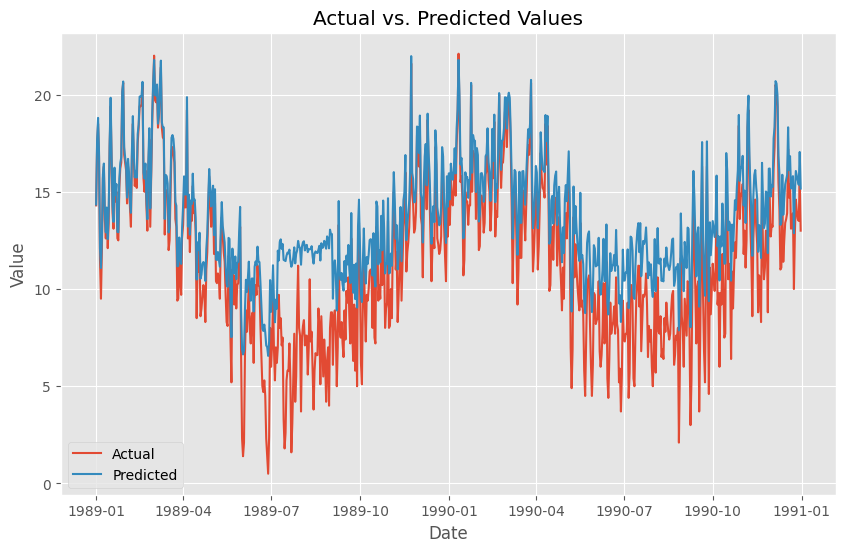

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data1, y_test, label='Actual')
plt.plot(data1, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

#Вывод - все очень неплохо если во временном ряде отсутствует тренд

Средняя абсолютная ошибка (MAE): Она измеряет среднее абсолютное отклонение предсказанных значений от фактических значений

In [52]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Средняя абсолютная ошибка (MAE):", mae)

Средняя абсолютная ошибка (MAE): 2.1312027397260294


Коэффициент детерминации (R^2): Он измеряет прогнозируемую долю дисперсии зависимой переменной, которую можно объяснить с помощью независимых переменных. Значение R^2 должно быть между 0 и 1, и чем ближе к 1, тем лучше модель.

In [53]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2)

Коэффициент детерминации (R^2): 0.5899597867549624


# Оценка важности признаков с помощью permutation_importance

In [54]:
from sklearn.inspection import permutation_importance
# Оценка важности признаков с помощью permutation_importance
importance = permutation_importance(model, X_test, y_test)

# Получение отсортированных индексов признаков по их важности
sorted_idx = importance.importances_mean.argsort()

#Посмотрим на то, чего получили из оценки важности признаков

#Это у нас индексы (номера столбцов), отсортированных по важности признаков

In [55]:
sorted_idx

array([118,  29,  59, 178, 388,  12, 268, 129, 194, 223, 224, 320,  21,
        73, 335, 279, 162, 369, 160,  41, 379, 105, 322, 246,  24, 408,
       132, 260, 133, 123, 173, 321, 342, 205, 247, 271, 108,  48,  96,
       227, 300, 109, 386,   3, 323, 147, 372, 219, 337, 399, 206, 202,
       254,  77, 270,  14, 119, 170, 282, 364, 243, 211, 324, 137, 362,
       241, 199, 340, 139,  82, 429,  38, 317, 135, 410, 417,  39, 158,
       204, 424, 263, 136,  81, 419, 184, 428, 434, 141,  67, 348, 327,
        56, 420, 120, 168, 106, 341, 237,  98, 349, 392, 355, 175,  32,
        18, 245, 207, 193, 236,   7,   5, 104, 230, 198,   8,  92, 222,
        25, 402, 125, 325, 289, 127, 311,  23, 347,  86, 134,  35,  90,
       330, 228,  10, 318,  31,  80, 286, 150, 171, 103, 385, 381, 213,
       143, 115, 358, 183, 287, 154, 167,  26,  45, 144, 414, 195, 319,
       306,  33, 215, 163, 196, 273, 235, 425, 159, 102, 189, 307,  11,
       391, 366, 350, 256, 232, 113, 186, 229, 214, 274, 303, 21

#А это у нас сам датафрейм с признаками, где столбцы отсортированы по важности

In [56]:
sorted_features = selected_features.iloc[:, sorted_idx]

In [57]:
sorted_features

,"y__fft_coefficient__attr_""abs""__coeff_4","y__fft_coefficient__attr_""real""__coeff_34","y__fft_coefficient__attr_""imag""__coeff_44","y__fft_coefficient__attr_""imag""__coeff_8",y__ratio_beyond_r_sigma__r_2,"y__fft_coefficient__attr_""imag""__coeff_33","y__agg_autocorrelation__f_agg_""median""__maxlag_40","y__fft_coefficient__attr_""angle""__coeff_44",y__autocorrelation__lag_7,"y__fft_coefficient__attr_""real""__coeff_48",...,"y__fft_coefficient__attr_""abs""__coeff_8",y__mean_second_derivative_central,"y__fft_coefficient__attr_""abs""__coeff_7","y__fft_coefficient__attr_""real""__coeff_38",y__time_reversal_asymmetry_statistic__lag_2,"y__fft_coefficient__attr_""abs""__coeff_5","y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0","y__fft_coefficient__attr_""real""__coeff_13",y__mean_change,"y__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0"
0,371.934737,-0.883836,-37.714214,-145.103790,0.000000,-49.843622,0.000000,-43.680950,0.587323,6.111358,...,441.465604,0.000769,512.179554,4.475208,0.000000,432.440992,0.000000,15.350079,-0.005225,0.000000
1,371.934737,-0.883836,-37.714214,-145.103790,0.000000,-49.843622,-1.000000,-43.680950,0.587323,6.111358,...,441.465604,0.000769,512.179554,4.475208,0.000000,432.440992,0.000000,15.350079,-2.800000,-2.800000
2,371.934737,-0.883836,-37.714214,-145.103790,0.000000,-49.843622,-0.470840,-43.680950,0.587323,6.111358,...,441.465604,1.850000,512.179554,4.475208,0.000000,432.440992,0.900000,15.350079,-0.950000,-0.950000
3,371.934737,-0.883836,-37.714214,-145.103790,0.000000,-49.843622,-0.209915,-43.680950,0.587323,6.111358,...,441.465604,-0.350000,512.179554,4.475208,0.000000,432.440992,-1.650000,15.350079,-2.033333,-2.033333
4,371.934737,-0.883836,-37.714214,-145.103790,0.000000,-49.843622,-0.503965,-43.680950,0.587323,6.111358,...,441.465604,0.666667,512.179554,4.475208,-3362.380000,432.440992,-0.700000,15.350079,-1.225000,-1.225000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,760.395951,-235.405597,-23.642732,-38.063317,0.046626,-196.512498,0.525251,-11.277278,0.575482,-228.299073,...,58.269952,0.000302,481.786654,297.518041,-2.701887,27.143404,0.015532,-197.720651,-0.001838,-0.001838
3646,762.743582,-235.998940,-10.696727,-44.540750,0.046614,-196.844153,0.525426,-5.377414,0.575504,-221.546842,...,55.996111,0.000329,476.672745,298.326638,-2.360653,25.742332,0.015376,-208.773857,-0.001947,-0.001947
3647,764.989567,-236.425816,2.008954,-50.872739,0.046601,-197.160547,0.525461,1.068326,0.575531,-214.997991,...,56.160222,0.000370,471.634999,298.713024,-2.299149,24.470856,0.015333,-219.974355,-0.001974,-0.001974
3648,769.418716,-234.384812,14.584635,-57.028465,0.046588,-197.324531,0.525393,8.047873,0.575541,-206.358290,...,58.152980,0.000685,466.077521,300.973569,-2.174159,23.867520,0.015333,-229.018095,-0.001371,-0.001371


#А это значения важности признаков

In [58]:
importance.importances_mean[sorted_idx]

array([-6.73006940e-02, -1.02048013e-02, -7.50555969e-03, -6.48133101e-03,
       -5.72094088e-03, -1.48533323e-03, -1.31297811e-03, -1.26011176e-03,
       -1.19816366e-03, -1.19342626e-03, -1.17987269e-03, -1.02383139e-03,
       -9.35465641e-04, -7.29851798e-04, -7.15228603e-04, -5.72001295e-04,
       -5.25149665e-04, -4.78137111e-04, -4.63986990e-04, -4.60103159e-04,
       -4.57425130e-04, -4.15846834e-04, -4.06880296e-04, -4.06577564e-04,
       -3.86001031e-04, -3.72505179e-04, -3.26654391e-04, -2.99802933e-04,
       -2.92245322e-04, -2.90741081e-04, -2.67540367e-04, -2.31519054e-04,
       -2.30936805e-04, -2.22336673e-04, -2.04691738e-04, -2.01572569e-04,
       -1.97750556e-04, -1.95578235e-04, -1.93930088e-04, -1.92813433e-04,
       -1.92133169e-04, -1.90459350e-04, -1.87478004e-04, -1.75623841e-04,
       -1.66855091e-04, -1.63539176e-04, -1.58518696e-04, -1.57901666e-04,
       -1.57559874e-04, -1.56925079e-04, -1.56718003e-04, -1.51333916e-04,
       -1.49156358e-04, -

#Приведем массивы к одному типу, чтобы питон не ругался при построении графиков

In [59]:
print(type(sorted_features))
print(type(importance.importances_mean[sorted_idx]))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [60]:
importances_df = pd.DataFrame(importance.importances_mean[sorted_idx])

##График важности признаков

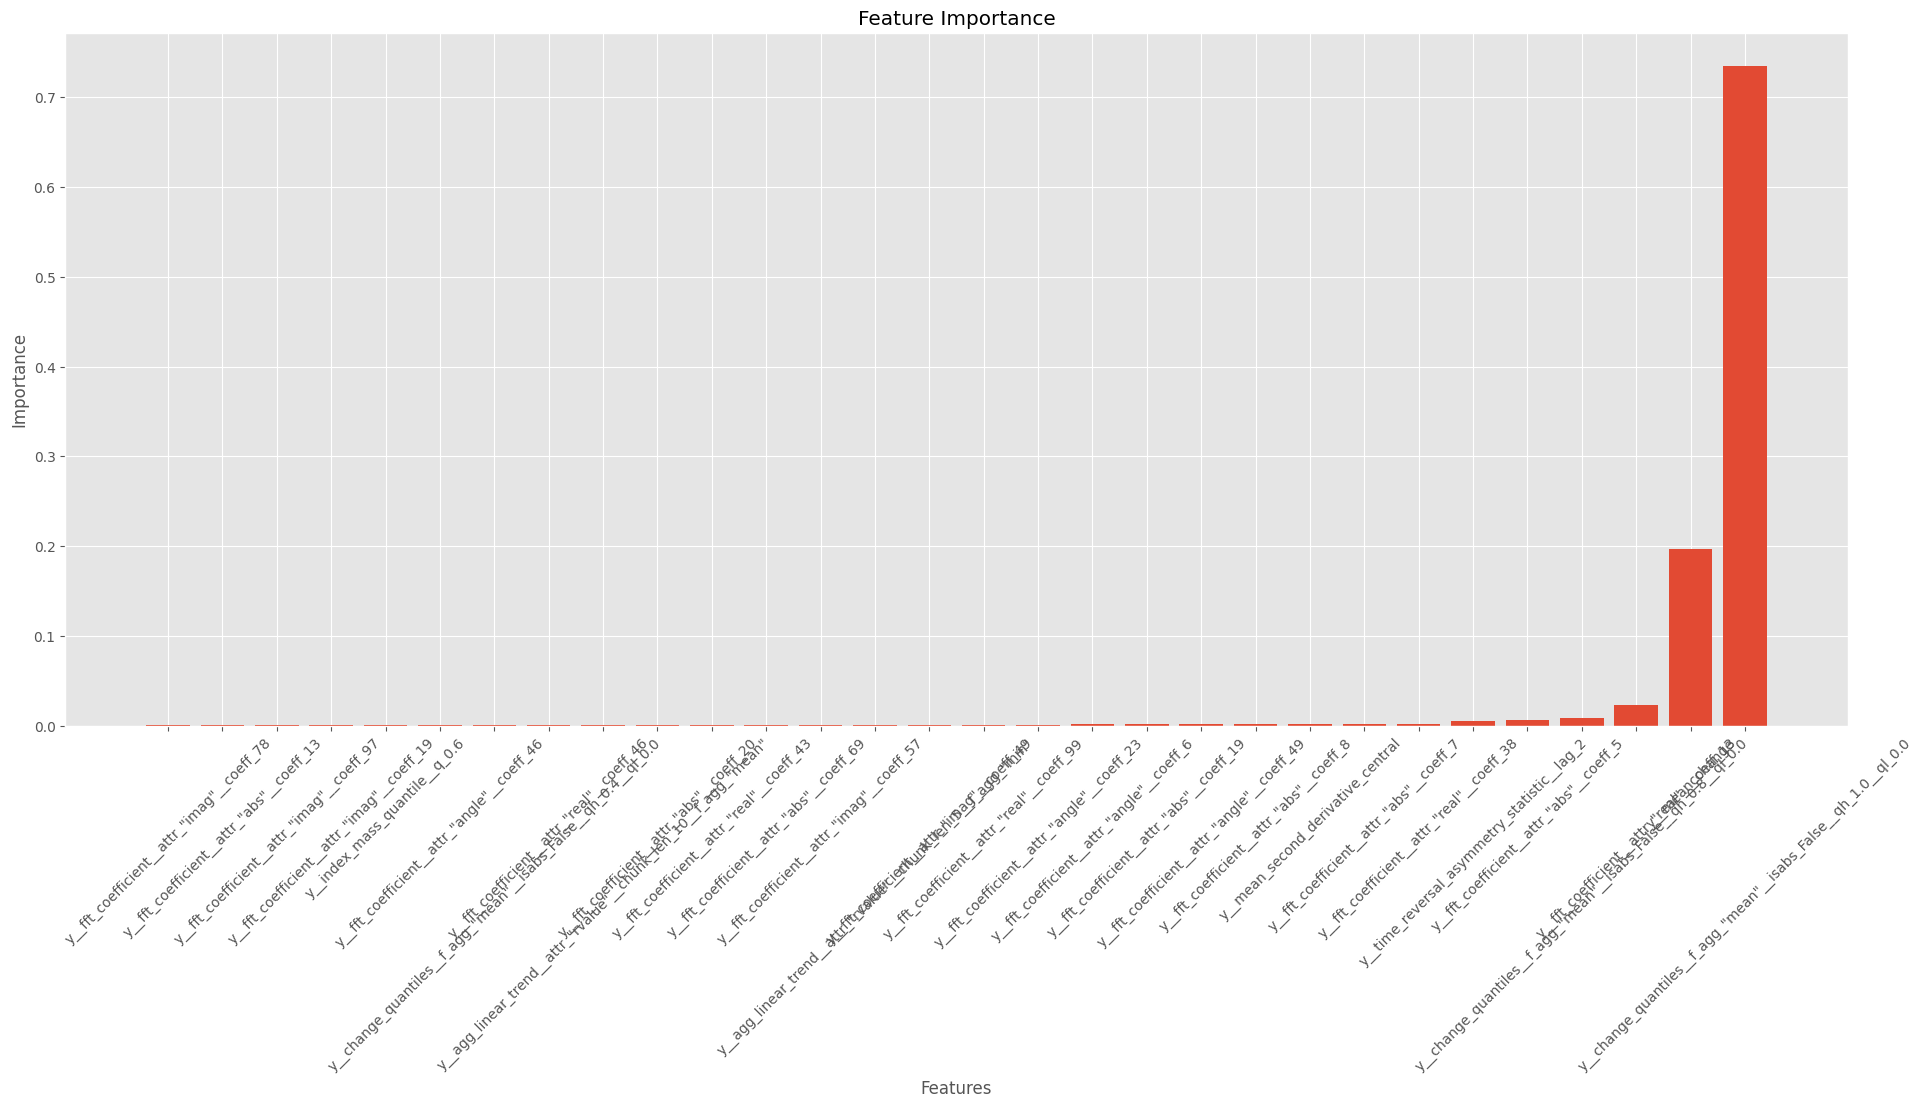

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Поворот названий колонок на 45 градусов
plt.xticks(rotation=45)

# Построение графика
#plt.bar(sorted_features.columns, importances_df[0])
# Построение графика с последними 30 признаками
n_features = 30
plt.bar(sorted_features.columns[-n_features:], importances_df[0][-n_features:])


# Настройка осей и названий
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')

# Отображение графика
plt.show()

#Вывод - не нравится мне эта картинка. Не должно так быть. все таки что то делаю неправильно.
Получается, что всего 3 -4 признака важные. Как предположение - не засунули мы часом саму целевую переменную в признаки всеми этими хитрыми манипуляциями с tsfresh?

#График обучения... ничего другого не смогла придумать
график зависимости метрики ошибки от количества деревьев (n_estimators) в  модели. Это может помочь визуализировать, каким образом увеличение количества деревьев влияет на качество модели

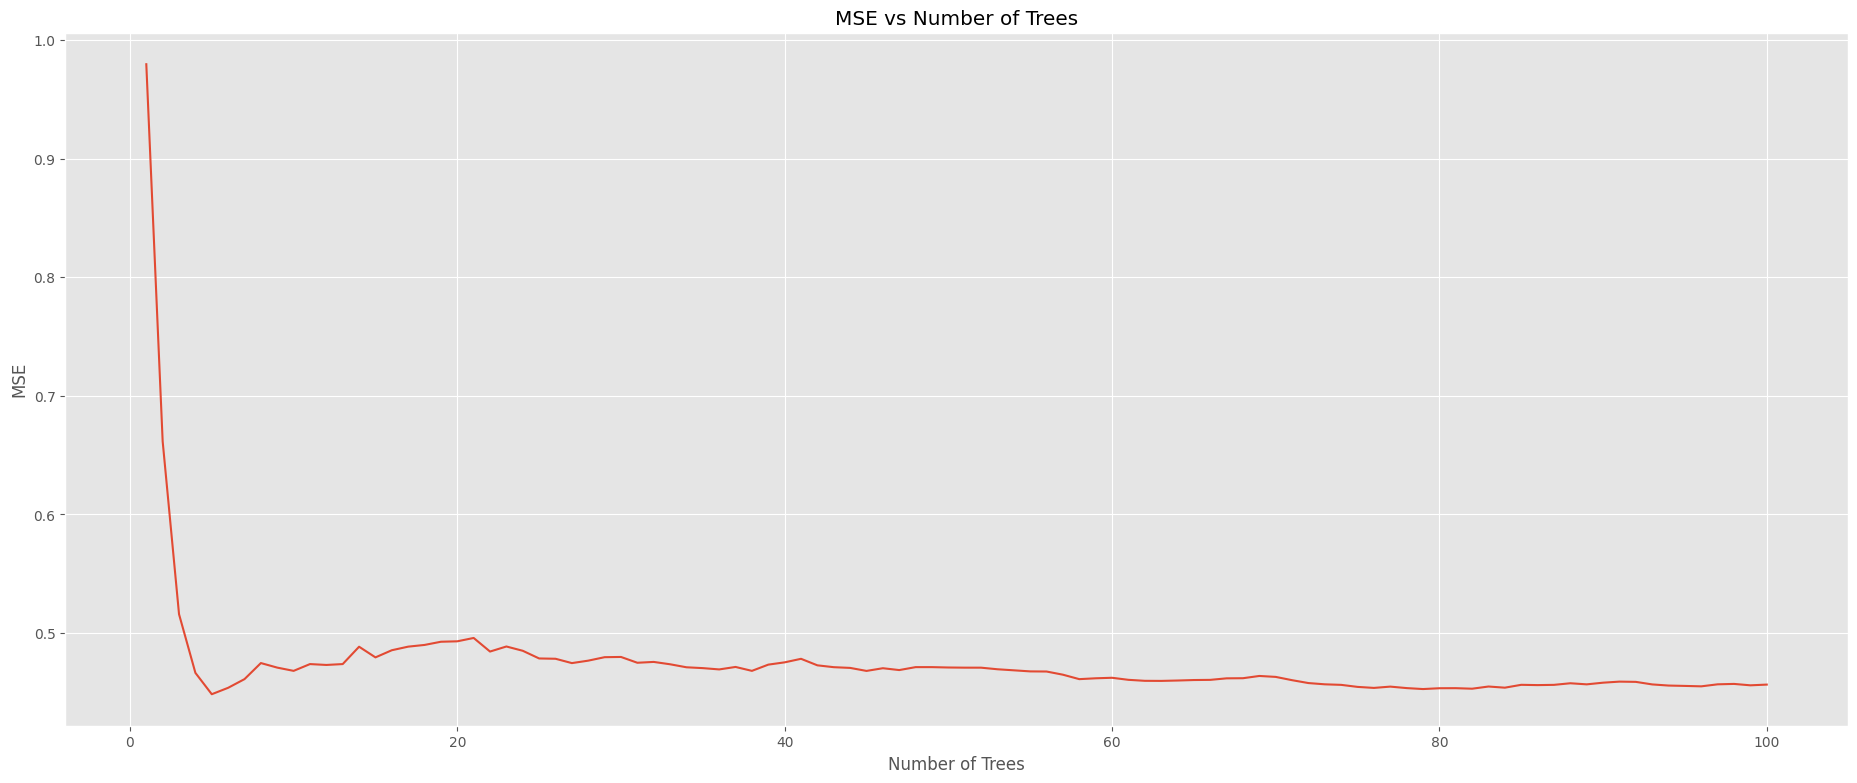

In [ ]:
# Создание пустого списка для хранения значений ошибки
errors = []

# Перебор различных значений n_estimators
for n in range(1, 101):
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    errors.append(mse)

# Построение графика
plt.plot(range(1, 101), errors)
plt.xlabel('Number of Trees')
plt.ylabel('MSE')
plt.title('MSE vs Number of Trees')

# Отображение графика
plt.show()

#Выберем 30 наиболее важных признаков

Это наши исходные данные, проверим, что они не запортились

In [62]:
importances_df

,0
0,-0.067301
1,-0.010205
2,-0.007506
3,-0.006481
4,-0.005721
...,...
430,0.006501
431,0.008626
432,0.023638
433,0.196358


In [63]:
sorted_features

,"y__fft_coefficient__attr_""abs""__coeff_4","y__fft_coefficient__attr_""real""__coeff_34","y__fft_coefficient__attr_""imag""__coeff_44","y__fft_coefficient__attr_""imag""__coeff_8",y__ratio_beyond_r_sigma__r_2,"y__fft_coefficient__attr_""imag""__coeff_33","y__agg_autocorrelation__f_agg_""median""__maxlag_40","y__fft_coefficient__attr_""angle""__coeff_44",y__autocorrelation__lag_7,"y__fft_coefficient__attr_""real""__coeff_48",...,"y__fft_coefficient__attr_""abs""__coeff_8",y__mean_second_derivative_central,"y__fft_coefficient__attr_""abs""__coeff_7","y__fft_coefficient__attr_""real""__coeff_38",y__time_reversal_asymmetry_statistic__lag_2,"y__fft_coefficient__attr_""abs""__coeff_5","y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0","y__fft_coefficient__attr_""real""__coeff_13",y__mean_change,"y__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0"
0,371.934737,-0.883836,-37.714214,-145.103790,0.000000,-49.843622,0.000000,-43.680950,0.587323,6.111358,...,441.465604,0.000769,512.179554,4.475208,0.000000,432.440992,0.000000,15.350079,-0.005225,0.000000
1,371.934737,-0.883836,-37.714214,-145.103790,0.000000,-49.843622,-1.000000,-43.680950,0.587323,6.111358,...,441.465604,0.000769,512.179554,4.475208,0.000000,432.440992,0.000000,15.350079,-2.800000,-2.800000
2,371.934737,-0.883836,-37.714214,-145.103790,0.000000,-49.843622,-0.470840,-43.680950,0.587323,6.111358,...,441.465604,1.850000,512.179554,4.475208,0.000000,432.440992,0.900000,15.350079,-0.950000,-0.950000
3,371.934737,-0.883836,-37.714214,-145.103790,0.000000,-49.843622,-0.209915,-43.680950,0.587323,6.111358,...,441.465604,-0.350000,512.179554,4.475208,0.000000,432.440992,-1.650000,15.350079,-2.033333,-2.033333
4,371.934737,-0.883836,-37.714214,-145.103790,0.000000,-49.843622,-0.503965,-43.680950,0.587323,6.111358,...,441.465604,0.666667,512.179554,4.475208,-3362.380000,432.440992,-0.700000,15.350079,-1.225000,-1.225000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,760.395951,-235.405597,-23.642732,-38.063317,0.046626,-196.512498,0.525251,-11.277278,0.575482,-228.299073,...,58.269952,0.000302,481.786654,297.518041,-2.701887,27.143404,0.015532,-197.720651,-0.001838,-0.001838
3646,762.743582,-235.998940,-10.696727,-44.540750,0.046614,-196.844153,0.525426,-5.377414,0.575504,-221.546842,...,55.996111,0.000329,476.672745,298.326638,-2.360653,25.742332,0.015376,-208.773857,-0.001947,-0.001947
3647,764.989567,-236.425816,2.008954,-50.872739,0.046601,-197.160547,0.525461,1.068326,0.575531,-214.997991,...,56.160222,0.000370,471.634999,298.713024,-2.299149,24.470856,0.015333,-219.974355,-0.001974,-0.001974
3648,769.418716,-234.384812,14.584635,-57.028465,0.046588,-197.324531,0.525393,8.047873,0.575541,-206.358290,...,58.152980,0.000685,466.077521,300.973569,-2.174159,23.867520,0.015333,-229.018095,-0.001371,-0.001371


# Получение 30 наиболее важных признаков

In [64]:
# Получение 30 наиболее важных признаков
top_features = importances_df[0].nlargest(30).index.tolist()
top_features

[434,
 433,
 432,
 431,
 430,
 429,
 428,
 427,
 426,
 425,
 424,
 423,
 422,
 421,
 420,
 419,
 418,
 417,
 416,
 415,
 414,
 413,
 412,
 411,
 410,
 409,
 408,
 407,
 406,
 405]

#Создадим новый датасет с 30 наиболее важными признаками

In [65]:
new_dataset = sorted_features.iloc[:, top_features].copy()

In [66]:
new_dataset

,"y__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0",y__mean_change,"y__fft_coefficient__attr_""real""__coeff_13","y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0","y__fft_coefficient__attr_""abs""__coeff_5",y__time_reversal_asymmetry_statistic__lag_2,"y__fft_coefficient__attr_""real""__coeff_38","y__fft_coefficient__attr_""abs""__coeff_7",y__mean_second_derivative_central,"y__fft_coefficient__attr_""abs""__coeff_8",...,"y__fft_coefficient__attr_""abs""__coeff_20","y__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","y__fft_coefficient__attr_""real""__coeff_46","y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0","y__fft_coefficient__attr_""angle""__coeff_46",y__index_mass_quantile__q_0.6,"y__fft_coefficient__attr_""imag""__coeff_19","y__fft_coefficient__attr_""imag""__coeff_97","y__fft_coefficient__attr_""abs""__coeff_13","y__fft_coefficient__attr_""imag""__coeff_78"
0,0.000000,-0.005225,15.350079,0.000000,432.440992,0.000000,4.475208,512.179554,0.000769,441.465604,...,179.354170,-0.075872,6.462646,0.000000,-37.690821,1.000000,-90.053365,-9.426130,213.072351,-23.771915
1,-2.800000,-2.800000,15.350079,0.000000,432.440992,0.000000,4.475208,512.179554,0.000769,441.465604,...,179.354170,-0.075872,6.462646,0.000000,-37.690821,1.000000,-90.053365,-9.426130,213.072351,-23.771915
2,-0.950000,-0.950000,15.350079,0.900000,432.440992,0.000000,4.475208,512.179554,1.850000,441.465604,...,179.354170,-0.075872,6.462646,0.000000,-37.690821,0.666667,-90.053365,-9.426130,213.072351,-23.771915
3,-2.033333,-2.033333,15.350079,-1.650000,432.440992,0.000000,4.475208,512.179554,-0.350000,441.465604,...,179.354170,-0.075872,6.462646,0.000000,-37.690821,0.750000,-90.053365,-9.426130,213.072351,-23.771915
4,-1.225000,-1.225000,15.350079,-0.700000,432.440992,-3362.380000,4.475208,512.179554,0.666667,441.465604,...,179.354170,-0.075872,6.462646,1.200000,-37.690821,0.600000,-90.053365,-9.426130,213.072351,-23.771915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,-0.001838,-0.001838,-197.720651,0.015532,27.143404,-2.701887,297.518041,481.786654,0.000302,58.269952,...,1010.253621,0.014406,-171.180298,0.048038,127.904252,0.608064,-265.392776,-203.185635,309.217158,8.847883
3646,-0.001947,-0.001947,-208.773857,0.015376,25.742332,-2.360653,298.326638,476.672745,0.000329,55.996111,...,1017.743269,0.014507,-181.976408,0.048038,130.542747,0.607897,-261.451050,-225.118219,316.634283,0.508694
3647,-0.001974,-0.001974,-219.974355,0.015333,24.470856,-2.299149,298.713024,471.634999,0.000370,56.160222,...,1025.228727,0.014565,-192.545724,0.048038,133.188112,0.608004,-257.716457,-244.855776,324.197163,-8.951454
3648,-0.001371,-0.001371,-229.018095,0.015333,23.867520,-2.174159,300.973569,466.077521,0.000685,58.152980,...,1030.860575,0.014956,-200.565722,0.048038,135.486756,0.608112,-254.115156,-261.573240,330.343480,-19.048905


#Делим на трейн и тест без перемешивания

In [75]:
X_train, X_test, y_train, y_test = train_test_split(new_dataset, datats['y'], test_size=0.2, random_state=42, shuffle=False)

# Создание и обучение модели RandomForestRegressor

In [77]:
# Создание и обучение модели RandomForestRegressor
model2 = RandomForestRegressor(n_estimators=100, random_state=42)

model2.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model2.predict(X_test)

# Оценка качества модели
mse = mean_squared_error(y_test, y_pred)
print("Среднеквадратичная ошибка (MSE):", mse)

Среднеквадратичная ошибка (MSE): 5.9360559479452055


In [78]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Средняя абсолютная ошибка (MAE):", mae)

Средняя абсолютная ошибка (MAE): 2.12175890410959


In [79]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2)

Коэффициент детерминации (R^2): 0.6475268105481973


In [80]:
X_test

,"y__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0",y__mean_change,"y__fft_coefficient__attr_""real""__coeff_13","y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0","y__fft_coefficient__attr_""abs""__coeff_5",y__time_reversal_asymmetry_statistic__lag_2,"y__fft_coefficient__attr_""real""__coeff_38","y__fft_coefficient__attr_""abs""__coeff_7",y__mean_second_derivative_central,"y__fft_coefficient__attr_""abs""__coeff_8",...,"y__fft_coefficient__attr_""abs""__coeff_20","y__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","y__fft_coefficient__attr_""real""__coeff_46","y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0","y__fft_coefficient__attr_""angle""__coeff_46",y__index_mass_quantile__q_0.6,"y__fft_coefficient__attr_""imag""__coeff_19","y__fft_coefficient__attr_""imag""__coeff_97","y__fft_coefficient__attr_""abs""__coeff_13","y__fft_coefficient__attr_""imag""__coeff_78"
2920,-0.002192,-0.002192,342.663804,0.028666,283.096821,-2.791244,86.018980,355.438483,0.000514,6023.579581,...,120.236236,-0.009576,-67.321509,0.066522,-107.756922,0.607669,-260.614193,137.058587,379.028989,-15.568891
2921,-0.001130,-0.001130,340.069794,0.028666,274.548671,-2.131434,97.825853,362.381093,0.001010,6028.712593,...,118.223648,-0.006778,-57.921385,0.066522,-105.133585,0.607803,-255.325814,148.038570,378.477603,-34.269962
2922,-0.000753,-0.000753,338.488689,0.028666,264.915625,-1.527106,110.527979,371.001430,0.000668,6034.698599,...,115.220262,-0.005187,-47.112867,0.066522,-102.228469,0.607937,-249.815725,155.503202,378.892777,-53.704101
2923,-0.001334,-0.001334,335.120746,0.028666,256.986503,-1.029431,121.307208,379.107046,0.000188,6038.964398,...,113.911524,-0.005157,-37.748673,0.066522,-99.735696,0.607729,-244.159853,158.910881,377.749968,-73.599766
2924,-0.003146,-0.003146,326.369003,0.028666,254.355087,-1.486607,126.569274,383.589764,-0.000428,6038.181287,...,117.806066,-0.007049,-33.449698,0.066522,-98.547323,0.607863,-238.581098,157.065457,371.849141,-94.284350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,-0.001838,-0.001838,-197.720651,0.015532,27.143404,-2.701887,297.518041,481.786654,0.000302,58.269952,...,1010.253621,0.014406,-171.180298,0.048038,127.904252,0.608064,-265.392776,-203.185635,309.217158,8.847883
3646,-0.001947,-0.001947,-208.773857,0.015376,25.742332,-2.360653,298.326638,476.672745,0.000329,55.996111,...,1017.743269,0.014507,-181.976408,0.048038,130.542747,0.607897,-261.451050,-225.118219,316.634283,0.508694
3647,-0.001974,-0.001974,-219.974355,0.015333,24.470856,-2.299149,298.713024,471.634999,0.000370,56.160222,...,1025.228727,0.014565,-192.545724,0.048038,133.188112,0.608004,-257.716457,-244.855776,324.197163,-8.951454
3648,-0.001371,-0.001371,-229.018095,0.015333,23.867520,-2.174159,300.973569,466.077521,0.000685,58.152980,...,1030.860575,0.014956,-200.565722,0.048038,135.486756,0.608112,-254.115156,-261.573240,330.343480,-19.048905


In [81]:
data1 = datats['date'][2920:]

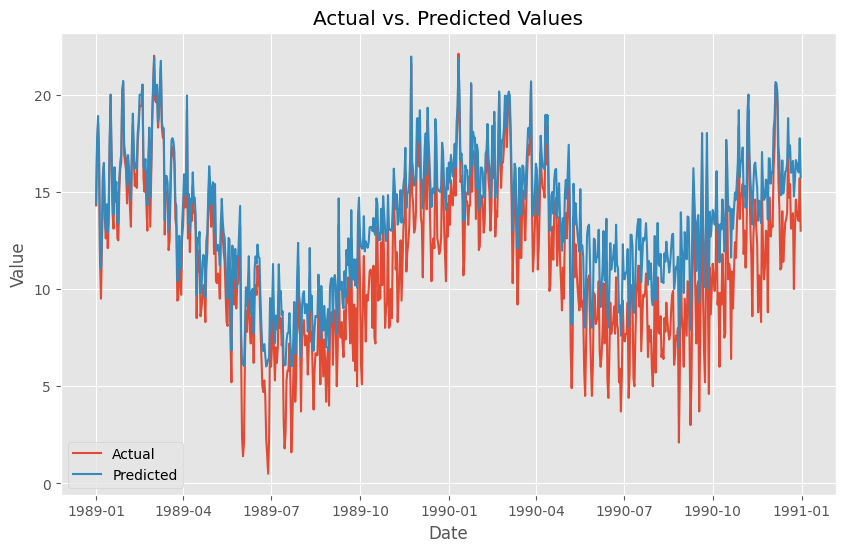

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data1, y_test, label='Actual')
plt.plot(data1, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

#Вывод - качество модели при использовании наиболее важных признаков немного улучшилось

#Наш исходный ряд

In [101]:
datats

,id,date,y
0,1,1981-01-01,20.7
1,1,1981-01-02,17.9
2,1,1981-01-03,18.8
3,1,1981-01-04,14.6
4,1,1981-01-05,15.8
...,...,...,...
3645,1,1990-12-27,14.0
3646,1,1990-12-28,13.6
3647,1,1990-12-29,13.5
3648,1,1990-12-30,15.7


#Сравнение с моделью LSTM

Сильно извиняюсь за keras, но в pytorch уж очень много кода. Хотела немного уменьшить количество листаемых страниц. (пример в pytorch у меня тоже работает)

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [103]:
# Получение нужных столбцов для прогнозирования ('Temperature (C)')
target_column = 'y'
target_data = datats[target_column].values.reshape(-1, 1)

In [104]:
target_data

array([[20.7],
       [17.9],
       [18.8],
       ...,
       [13.5],
       [15.7],
       [13. ]])

In [105]:
# Нормализация данных в диапазоне от 0 до 1
scaler = MinMaxScaler()
target_data = scaler.fit_transform(target_data)

In [106]:
# Разделение данных на обучающую и тестовую выборки
train_size = int(len(target_data) * 0.8)
train_data, test_data = target_data[:train_size], target_data[train_size:]


In [107]:
# Функция для создания последовательной выборки
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [108]:
# Задание длины последовательности и создание последовательных выборок для обучения и тестирования
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [109]:
# Создание модели LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=Adam(), loss='mse')

In [110]:
# Обучение модели LSTM
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
46/46 [==============================] - 4s 23ms/step - loss: 0.0300 - val_loss: 0.0102
Epoch 2/20
46/46 [==============================] - 1s 12ms/step - loss: 0.0116 - val_loss: 0.0098
Epoch 3/20
46/46 [==============================] - 1s 11ms/step - loss: 0.0113 - val_loss: 0.0095
Epoch 4/20
46/46 [==============================] - 1s 12ms/step - loss: 0.0112 - val_loss: 0.0096
Epoch 5/20
46/46 [==============================] - 1s 11ms/step - loss: 0.0111 - val_loss: 0.0094
Epoch 6/20
46/46 [==============================] - 1s 11ms/step - loss: 0.0112 - val_loss: 0.0093
Epoch 7/20
46/46 [==============================] - 1s 11ms/step - loss: 0.0109 - val_loss: 0.0091
Epoch 8/20
46/46 [==============================] - 1s 12ms/step - loss: 0.0108 - val_loss: 0.0090
Epoch 9/20
46/46 [==============================] - 1s 11ms/step - loss: 0.0107 - val_loss: 0.0090
Epoch 10/20
46/46 [==============================] - 1s 12ms/step - loss: 0.0107 - val_loss: 0.0088
Epoch 11/

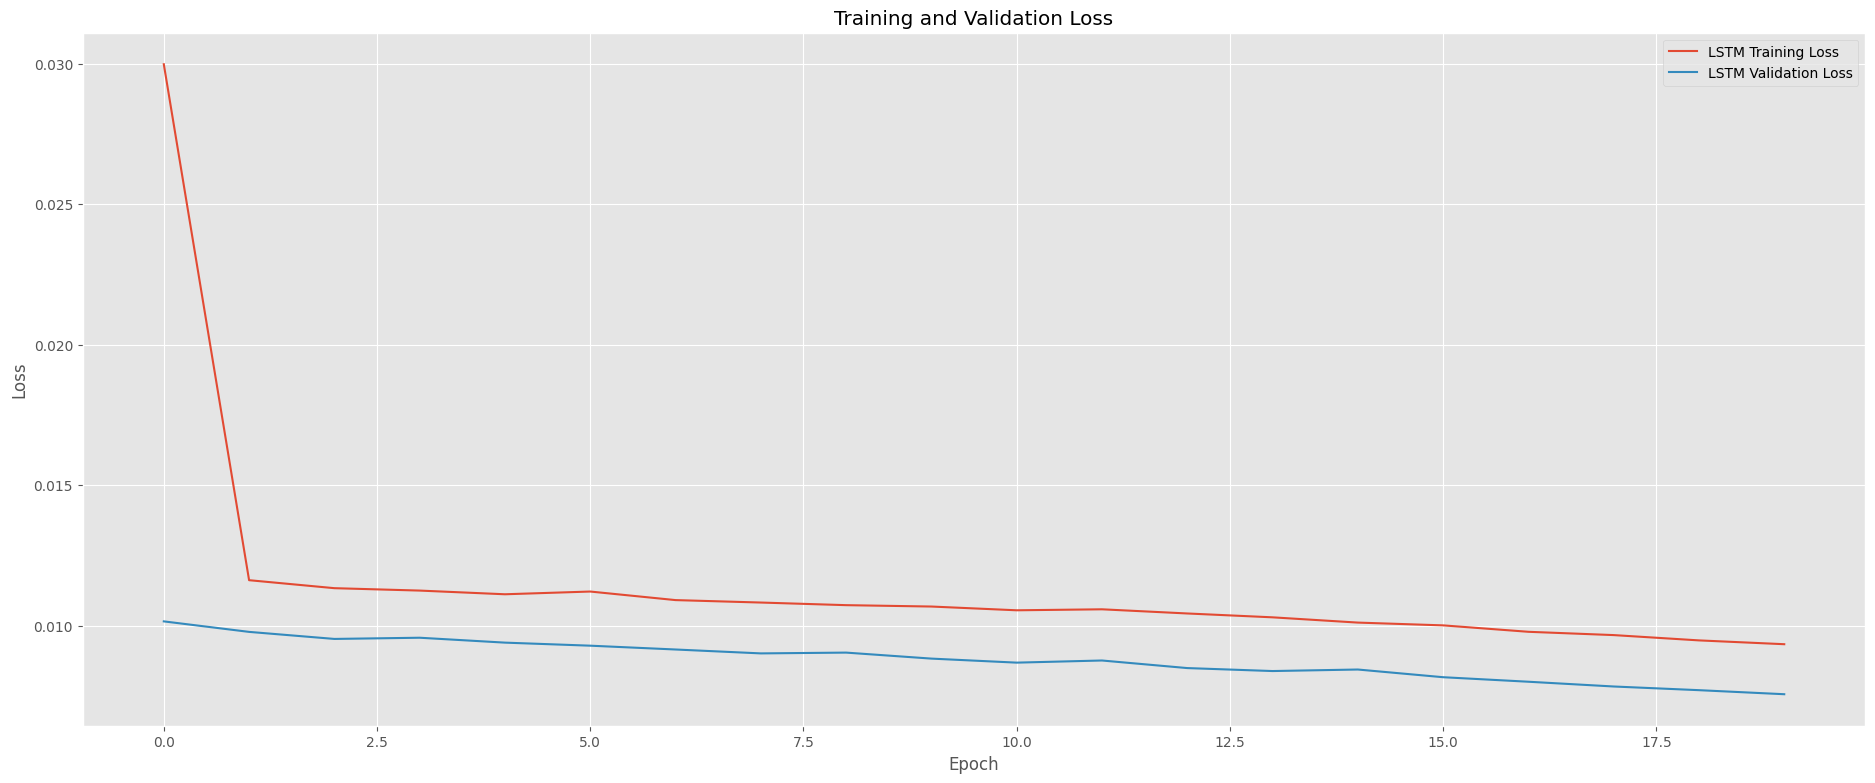

In [111]:
# Визуализация графика потерь в процессе обучения
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [112]:
# Получение прогноза для тестовой выборки
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

23/23 [==============================] - 1s 4ms/step


In [113]:
# Вычисление метрик качества прогноза
mse_lstm = mean_squared_error(y_test, y_pred_lstm)

In [114]:
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

In [115]:
print('LSTM')
print('Mean Squared Error:', mse_lstm)
print('Mean Absolute Error:', mae_lstm)

LSTM
Mean Squared Error: 126.53306307970577
Mean Absolute Error: 10.826603550428976


#Однако. Метрики качества у LSTM получились хуже, чем у RandomForestRegressor

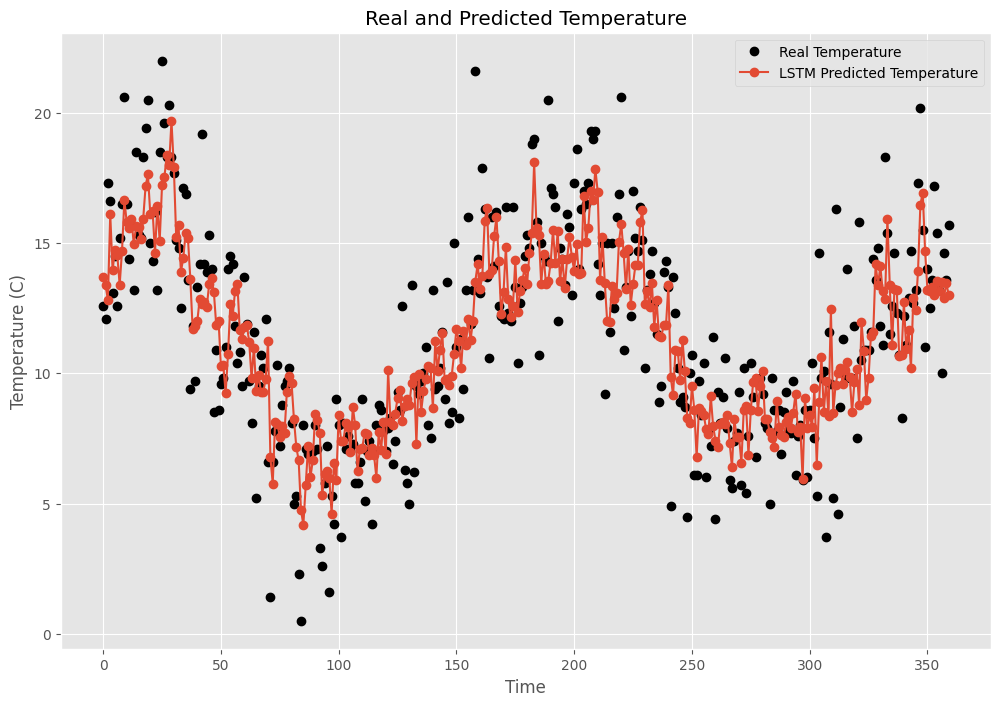

In [118]:
# Установка размера области графиков
plt.figure(figsize=(12, 8))

# Визуализация графика реальных и прогнозируемых значений температуры, отображая только каждую пятидесятую точку
plt.plot(scaler.inverse_transform(y_test)[::2], color='black', marker='o', linestyle='', label='Real Temperature')
plt.plot(y_pred_lstm[::2], marker='o', linestyle='-', label='LSTM Predicted Temperature')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.title('Real and Predicted Temperature')
plt.show()